# Hierarchical Clustering
    Interpretable Customer Segmentation Without Predefining K
## Objective

This notebook provides a structured and interpretable treatment of hierarchical clustering, covering:

- When hierarchical clustering is preferable to K-Means

- Agglomerative vs divisive approaches

- Linkage methods and distance metrics

- Dendrogram interpretation

- Practical clustering decisions in finance

It answers:

    How can we discover customer segments when we don’t know how many exist?

## Business Context – Why Hierarchical Clustering in Finance?

Hierarchical clustering is widely used when:

- Interpretability matters more than scale

- Stakeholders want structure, not just labels

- The number of segments is unknown

- Regulatory transparency is required

Typical use cases:

- Banking customer segmentation

- Portfolio grouping

- Risk tier discovery

> Product bundling analysis

## Imports and Dataset

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("D:/GitHub/Data-Science-Techniques/datasets/Unsupervised/synthetic_bank_customer_segmentation.csv")

df.head()

,age,annual_income,avg_monthly_spend,credit_utilization,tenure_years,num_products,risk_score
0,56,106477.0,5268.0,0.06,3.1,1,24.1
1,69,109688.0,2206.0,0.00,2.0,1,22.0
2,46,94629.0,2998.0,0.22,3.2,1,36.1
3,32,49359.0,1725.0,0.17,4.6,1,24.4
4,60,91565.0,1807.0,0.06,21.3,7,17.3


### Dataset Features


| Feature            | Description          |
| ------------------ | -------------------- |
| age                | Customer age         |
| annual_income      | Annual income        |
| avg_monthly_spend  | Monthly spend        |
| credit_utilization | Credit usage ratio   |
| tenure_years       | Years with bank      |
| num_products       | Products owned       |
| risk_score         | Internal risk metric |



## Feature Selection

Hierarchical clustering is distance-based and requires numerical features.

### Select Features

In [2]:
features = [
    "age",
    "annual_income",
    "avg_monthly_spend",
    "credit_utilization",
    "tenure_years",
    "num_products",
    "risk_score"
]

X = df[features]


## Scaling (Mandatory)

Hierarchical clustering is extremely sensitive to scale.

### Standardization

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### Distance Matrix (Conceptual)

Hierarchical clustering builds a tree of merges using pairwise distances.

Common distance metrics:

- Euclidean (default)

- Manhattan

- Cosine

# MODELS

## Linkage Methods (Critical Choice)

| Linkage  | Behavior                            |
| -------- | ----------------------------------- |
| single   | Chaining (sensitive to noise)       |
| complete | Compact clusters                    |
| average  | Balanced                            |
| ward     | Variance minimization (recommended) |



> `[ok] - ` Ward linkage is most common in finance.

## Dendrogram Construction
### Dendrogram

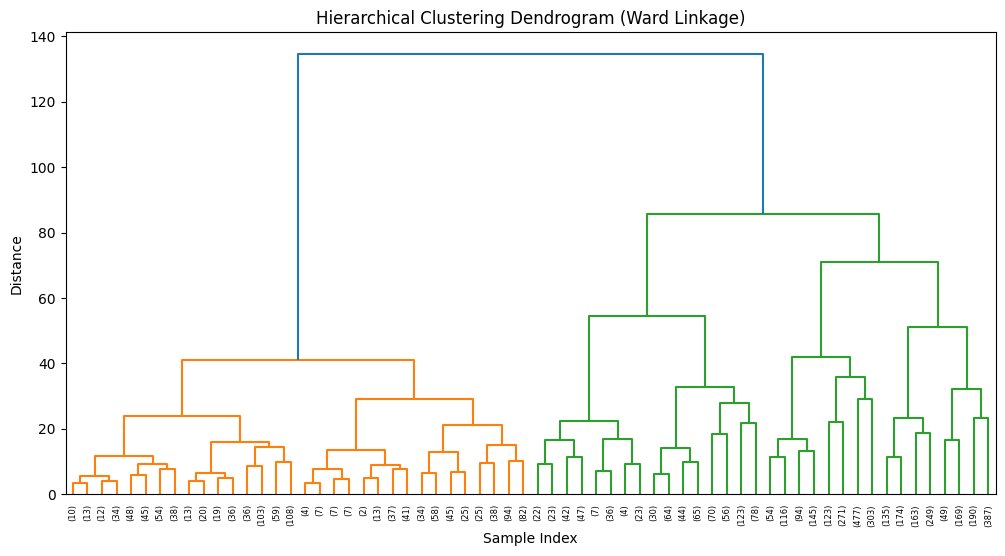

In [4]:
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(X_scaled, method="ward")

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Hierarchical Clustering Dendrogram (Ward Linkage)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()


### How to Read a Dendrogram

- Height = dissimilarity at merge

- Large vertical jumps = natural splits

- Horizontal cut = number of clusters

Hierarchical clustering shows structure, not just labels.

### Choosing Number of Clusters

Look for:

- Large vertical gaps

- Business interpretability

- Operational usability

Assume:

In [5]:
n_clusters = 4

## Agglomerative Clustering
### Model Fit

In [6]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(
    n_clusters=4,
    metric="euclidean",
    linkage="ward"
)

df["cluster"] = agg.fit_predict(X_scaled)


### Cluster Size Check

In [7]:
df["cluster"].value_counts().sort_index()

cluster
0     734
1    1583
2    1516
3    1167
Name: count, dtype: int64

- `[ok] -` Moderate imbalance is acceptable
- `[no] -` Extreme imbalance may indicate noise

### – Cluster Profiling

This is the most important step.

#### Cluster Means

In [8]:
cluster_profile = (
    df
    .groupby("cluster")[features]
    .mean()
    .round(2)
)

cluster_profile


,age,annual_income,avg_monthly_spend,credit_utilization,tenure_years,num_products,risk_score
cluster,,,,,,,
0,43.90,80701.63,2618.76,0.18,10.98,3.77,24.73
1,60.60,107325.29,3672.99,0.05,4.37,1.83,20.34
2,45.24,85130.48,2864.46,0.17,2.84,1.58,28.45
3,29.14,57243.98,1837.99,0.38,3.00,1.65,41.99


#### Example Business Interpretation

| Cluster | Description                         |
| ------- | ----------------------------------- |
| 0       | Young, low income, high utilization |
| 1       | High income, loyal, low risk        |
| 2       | Mid-income, high spend              |
| 3       | Older, conservative, low engagement |


Hierarchical clusters are often more interpretable than K-Means.

#### Visualization via PCA

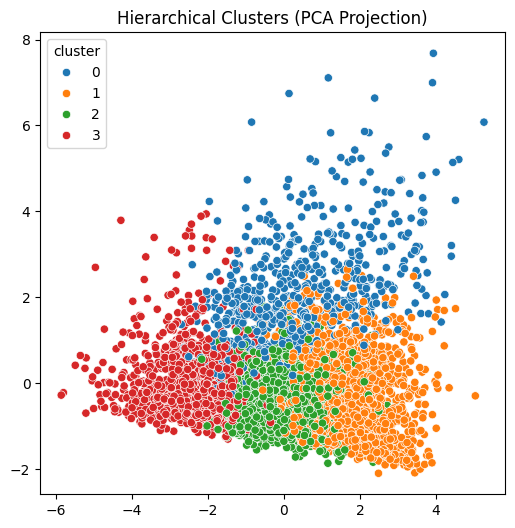

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df["cluster"],
    palette="tab10"
)
plt.title("Hierarchical Clusters (PCA Projection)")
plt.show()


PCA is only for visualization.

## Hierarchical vs K-Means


| Aspect              | Hierarchical | K-Means |
| ------------------- | ------------ | ------- |
| Needs K upfront     | ❌            | ✔       |
| Interpretability    | High         | Medium  |
| Scalability         | Low          | High    |
| Deterministic       | ✔            | ❌       |
| Outlier sensitivity | High         | High    |





## Limitations (Important)

- `[neg] - ` Does not scale well (>50k rows)
- `[neg] - ` Sensitive to noise
- `[neg] - ` No reassignment after merge
- `[neg] - ` Computationally expensive

## Common Mistakes (Avoided)

- `[neg] - ` Skipping scaling
- `[neg] - ` Using categorical features
- `[neg] - ` Blindly cutting dendrogram
- `[neg] - ` Treating clusters as ground truth
- `[neg] - ` Ignoring business constraints

## Summary Table

| Component     | Recommendation        |
| ------------- | --------------------- |
| Distance      | Euclidean             |
| Linkage       | Ward                  |
| Scaling       | Mandatory             |
| Cluster Count | Business + dendrogram |
| Use Case      | Interpretability      |


## Key Takeaways

- Hierarchical clustering reveals structure

- Dendrograms support decision-making

- Ward linkage is finance-friendly

- Interpretability beats automation

- Not suitable for large datasets

##  Next Notebook
05_Unsupervised_Learning/

- └── 01_clustering/

   -└── [03_density_based_clustering](03_density_based_clustering.ipynb)

<br><br><br><br><br>



# Complete: [Data Science Techniques](https://github.com/lei-soares/Data-Science-Techniques)

- [00_Data_Generation_and_Simulation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/00_Data_Generation_and_Simulation)


- [01_Exploratory_Data_Analysis_(EDA)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/01_Exploratory_Data_Analysis_(EDA))


- [02_Data_Preprocessing](https://github.com/lei-soares/Data-Science-Techniques/tree/main/02_Data_Preprocessing)


- [03_Feature_Engineering](https://github.com/lei-soares/Data-Science-Techniques/tree/main/03_Feature_Engineering)


- [04_Supervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/04_Supervised_Learning)

    - [Regression Models](https://github.com/lei-soares/Data-Science-Techniques/tree/49de369e0600a513b54445e8cb4196b26ce71853/04_Supervised_Learning/01_regression_models)
    
    - [Classification Models](https://github.com/lei-soares/Data-Science-Techniques/tree/49de369e0600a513b54445e8cb4196b26ce71853/04_Supervised_Learning/02_classification_models)


- [05_Unsupervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/05_Unsupervised_Learning)


- [06_Model_Evaluation_and_Validation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/06_Model_Evaluation_and_Validation)


- [07_Model_Tuning_and_Optimization](https://github.com/lei-soares/Data-Science-Techniques/tree/main/07_Model_Tuning_and_Optimization)


- [08_Interpretability_and_Explainability](https://github.com/lei-soares/Data-Science-Techniques/tree/main/08_Interpretability_and_Explainability)


- [09_Pipelines_and_Workflows](https://github.com/lei-soares/Data-Science-Techniques/tree/main/09_Pipelines_and_Workflows)


- [10_Natural_Language_Processing_(NLP)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/10_Natural_Language_Processing_(NLP))


- [11_Time_Series](https://github.com/lei-soares/Data-Science-Techniques/tree/main/11_Time_Series)


- [12_Anomaly_and_Fraud_Detection](https://github.com/lei-soares/Data-Science-Techniques/tree/main/12_Anomaly_and_Fraud_Detection)


- [13_Imbalanced_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/13_Imbalanced_Learning)


- [14_Deployment_and_Production_Concepts](https://github.com/lei-soares/Data-Science-Techniques/tree/main/14_Deployment_and_Production_Concepts)


- [15_Business_and_Experimental_Design](https://github.com/lei-soares/Data-Science-Techniques/tree/main/15_Business_and_Experimental_Design)




<br><br><br><br><br>

[Panfugo Dados](www.pantufodados.com)


[Pantufo Dados - YouTube Channel](https://www.youtube.com/@pantufodados)